In [1]:
# Example
# python demo.py --net res101 --dataset vg --load_dir models --cuda
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import _init_paths
import os
import sys
import numpy as np
import argparse
import pprint
import pdb
import time
import cv2
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.datasets as dset
# from scipy.misc import imread
from imageio import imread
from roi_data_layer.roidb import combined_roidb
from roi_data_layer.roibatchLoader import roibatchLoader
from model.utils.config import cfg, cfg_from_file, cfg_from_list, get_output_dir
from model.rpn.bbox_transform import clip_boxes
# from model.nms.nms_wrapper import nms
from model.roi_layers import nms
from model.rpn.bbox_transform import bbox_transform_inv
from model.utils.net_utils import save_net, load_net, vis_detections
from model.utils.blob import im_list_to_blob
from model.faster_rcnn.vgg16 import vgg16
from model.faster_rcnn.resnet import resnet
import pdb

import matplotlib.pyplot as plt

ImportError: cannot import name '_mask' from 'pycocotools' (/home/alex/Faster-R-CNN-with-model-pretrained-on-Visual-Genome/lib/pycocotools/__init__.py)

In [ ]:
try:
    xrange          # Python 2
except NameError:
    xrange = range  # Python 3

In [ ]:
lr = cfg.TRAIN.LEARNING_RATE
momentum = cfg.TRAIN.MOMENTUM
weight_decay = cfg.TRAIN.WEIGHT_DECAY


conf_thresh = 0.4
MIN_BOXES = 10
MAX_BOXES = 36

def _get_image_blob(im):
  """Converts an image into a network input.
  Arguments:
    im (ndarray): a color image in BGR order
  Returns:
    blob (ndarray): a data blob holding an image pyramid
    im_scale_factors (list): list of image scales (relative to im) used
      in the image pyramid
  """
  im_orig = im.astype(np.float32, copy=True)
  im_orig -= cfg.PIXEL_MEANS

  im_shape = im_orig.shape
  im_size_min = np.min(im_shape[0:2])
  im_size_max = np.max(im_shape[0:2])

  processed_ims = []
  im_scale_factors = []

  for target_size in cfg.TEST.SCALES:
      im_scale = float(target_size) / float(im_size_min)
      # Prevent the biggest axis from being more than MAX_SIZE
      if np.round(im_scale * im_size_max) > cfg.TEST.MAX_SIZE:
        im_scale = float(cfg.TEST.MAX_SIZE) / float(im_size_max)
      im = cv2.resize(im_orig, None, None, fx=im_scale, fy=im_scale,
              interpolation=cv2.INTER_LINEAR)
      im_scale_factors.append(im_scale)
      processed_ims.append(im)

  # Create a blob to hold the input images
  blob = im_list_to_blob(processed_ims)

  return blob, np.array(im_scale_factors)

In [ ]:
class Args():
    def __init__(self,dataset='vg',cfg='cfgs/res101.yml',net='res101',load_dir='data/faster_rcnn',\
                 image_dir='images',image_file='img1.jpg',classes_dir='data/genome/1600-400-20',\
                    cuda=False,mGPUs=False,set=None,cag=False,parallel_type=0,vis=False):
        self.dataset=dataset
        self.cfg_file=cfg
        self.net=net
        self.load_dir=load_dir
        self.image_dir=image_dir
        self.image_file=image_file
        self.classes_dir=classes_dir
        self.cuda=cuda
        self.mGPUs=mGPUs
        self.set_cfgs=set
        self.class_agnostic=cag
        self.parallel_type=parallel_type
        self.vis=vis
args = Args(net='res101',dataset='vg')
# set cfg according to the dataset used to train the pre-trained model
if args.dataset == "pascal_voc":
    args.set_cfgs = ['ANCHOR_SCALES', '[8, 16, 32]', 'ANCHOR_RATIOS', '[0.5,1,2]']
elif args.dataset == "pascal_voc_0712":
    args.set_cfgs = ['ANCHOR_SCALES', '[8, 16, 32]', 'ANCHOR_RATIOS', '[0.5,1,2]']
elif args.dataset == "coco":
    args.set_cfgs = ['ANCHOR_SCALES', '[4, 8, 16, 32]', 'ANCHOR_RATIOS', '[0.5,1,2]']
elif args.dataset == "imagenet":
    args.set_cfgs = ['ANCHOR_SCALES', '[8, 16, 32]', 'ANCHOR_RATIOS', '[0.5,1,2]']
elif args.dataset == "vg":
    args.set_cfgs = ['ANCHOR_SCALES', '[4, 8, 16, 32]', 'ANCHOR_RATIOS', '[0.5,1,2]']

if args.cfg_file is not None:
    cfg_from_file(args.cfg_file)
if args.set_cfgs is not None:
    cfg_from_list(args.set_cfgs)

cfg.USE_GPU_NMS = args.cuda

# print('Using config:')
# pprint.pprint(cfg)
np.random.seed(cfg.RNG_SEED)
        

/Users/liuhongbo/Desktop/Faster-R-CNN-with-model-pretrained-on-Visual-Genome/lib/model/utils/config.py:374: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  yaml_cfg = edict(yaml.load(f))


In [ ]:
# Load faster rcnn model
if not os.path.exists(args.load_dir):
    raise Exception('There is no input directory for loading network from ' + args.load_dir)
load_name = os.path.join(args.load_dir, 'faster_rcnn_{}_{}.pth'.format(args.net, args.dataset))

# Load classes
classes = ['__background__']
with open(os.path.join(args.classes_dir, 'objects_vocab.txt')) as f:
    for object in f.readlines():
        classes.append(object.split(',')[0].lower().strip())

In [ ]:
fasterRCNN = resnet(classes, 101, pretrained=False, class_agnostic=args.class_agnostic)

In [ ]:
print(fasterRCNN)

resnet(
  (RCNN_rpn): _RPN(
    (RPN_Conv): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (RPN_cls_score): Conv2d(512, 24, kernel_size=(1, 1), stride=(1, 1))
    (RPN_bbox_pred): Conv2d(512, 48, kernel_size=(1, 1), stride=(1, 1))
    (RPN_proposal): _ProposalLayer()
    (RPN_anchor_target): _AnchorTargetLayer()
  )
  (RCNN_proposal_target): _ProposalTargetLayer()
  (RCNN_roi_pool): ROIPool(output_size=(7, 7), spatial_scale=0.0625)
  (RCNN_roi_align): ROIAlign(output_size=(7, 7), spatial_scale=0.0625, sampling_ratio=0)
)


In [ ]:
fasterRCNN.create_architecture()

In [ ]:
print("load checkpoint %s" % (load_name))
checkpoint = torch.load(load_name, map_location=(lambda storage, loc: storage))
fasterRCNN.load_state_dict(checkpoint['model'])

load checkpoint models/faster_rcnn_res101_vg.pth


In [ ]:
print(fasterRCNN)

resnet(
  (RCNN_rpn): _RPN(
    (RPN_Conv): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (RPN_cls_score): Conv2d(512, 24, kernel_size=(1, 1), stride=(1, 1))
    (RPN_bbox_pred): Conv2d(512, 48, kernel_size=(1, 1), stride=(1, 1))
    (RPN_proposal): _ProposalLayer()
    (RPN_anchor_target): _AnchorTargetLayer()
  )
  (RCNN_proposal_target): _ProposalTargetLayer()
  (RCNN_roi_pool): ROIPool(output_size=(7, 7), spatial_scale=0.0625)
  (RCNN_roi_align): ROIAlign(output_size=(7, 7), spatial_scale=0.0625, sampling_ratio=0)
  (RCNN_base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): Bat

In [ ]:
# initilize the tensor holder here.
im_data = torch.FloatTensor(1)
im_info = torch.FloatTensor(1)
num_boxes = torch.LongTensor(1)
gt_boxes = torch.FloatTensor(1)
# make variable
with torch.no_grad():
    im_data = Variable(im_data)
    im_info = Variable(im_info)
    num_boxes = Variable(num_boxes)
    gt_boxes = Variable(gt_boxes)

In [ ]:
fasterRCNN.eval()

start = time.time()
max_per_image = 100
thresh = 0.05
vis = True

In [ ]:
im_file = os.path.join(args.image_dir, args.image_file)
# im = cv2.imread(im_file)
im_in = np.array(imread(im_file))
if len(im_in.shape) == 2:
    im_in = im_in[:,:,np.newaxis]
    im_in = np.concatenate((im_in,im_in,im_in), axis=2)
# rgb -> bgr
im = im_in[:,:,::-1]

blobs, im_scales = _get_image_blob(im)
assert len(im_scales) == 1, "Only single-image batch implemented"
im_blob = blobs
im_info_np = np.array([[im_blob.shape[1], im_blob.shape[2], im_scales[0]]], dtype=np.float32)

im_data_pt = torch.from_numpy(im_blob)
im_data_pt = im_data_pt.permute(0, 3, 1, 2)
im_info_pt = torch.from_numpy(im_info_np)

In [ ]:
with torch.no_grad():
        im_data.resize_(im_data_pt.size()).copy_(im_data_pt)
        im_info.resize_(im_info_pt.size()).copy_(im_info_pt)
        gt_boxes.resize_(1, 1, 5).zero_()
        num_boxes.resize_(1).zero_()
# pdb.set_trace()
det_tic = time.time()

rois, cls_prob, bbox_pred, \
rpn_loss_cls, rpn_loss_box, \
RCNN_loss_cls, RCNN_loss_bbox, \
rois_label = fasterRCNN(im_data, im_info, gt_boxes, num_boxes)

scores = cls_prob.data
boxes = rois.data[:, :, 1:5]


In [ ]:
print(im_data)
print(im_info)
print(gt_boxes)
print(num_boxes)

tensor([[[[-102.9801, -102.9801, -102.9801,  ..., -100.0093, -100.5976,
           -100.9801],
          [-102.9801, -102.9801, -102.9801,  ..., -100.0093, -100.5976,
           -100.9801],
          [-102.9801, -102.9801, -102.9801,  ..., -100.0093, -100.5976,
           -100.9801],
          ...,
          [ -33.5551,  -37.2845,  -43.0207,  ...,   17.9017,   20.0565,
             21.4574],
          [ -41.7918,  -41.0204,  -39.8339,  ...,   16.6736,   17.7899,
             18.5157],
          [ -45.9801,  -42.9201,  -38.2134,  ...,   16.0491,   16.6374,
             17.0199]],

         [[-114.9465, -114.9465, -114.9465,  ..., -111.9757, -112.5640,
           -112.9465],
          [-114.9465, -114.9465, -114.9465,  ..., -111.9757, -112.5640,
           -112.9465],
          [-114.9465, -114.9465, -114.9465,  ..., -111.9757, -112.5640,
           -112.9465],
          ...,
          [ -92.4090,  -90.4439,  -87.4213,  ...,  -55.4656,  -59.1279,
            -61.5090],
          [-100.05

In [ ]:
print(im_data.shape)
print(im_info.shape)
print(gt_boxes.shape)
print(num_boxes.shape)

torch.Size([1, 3, 850, 600])
torch.Size([1, 3])
torch.Size([1, 1, 5])
torch.Size([1])


In [ ]:
from torchinfo import summary
summary(fasterRCNN, input_size=[(1, 3, 850, 600), (1, 3), (1, 1, 5), (1,)],depth=1000)


Layer (type:depth-idx)                        Output Shape              Param #
resnet                                        [1, 300, 5]               --
├─Sequential: 1-1                             [1, 1024, 53, 38]         --
│    └─Conv2d: 2-1                            [1, 64, 425, 300]         (9,408)
│    └─BatchNorm2d: 2-2                       [1, 64, 425, 300]         (128)
│    └─ReLU: 2-3                              [1, 64, 425, 300]         --
│    └─MaxPool2d: 2-4                         [1, 64, 212, 150]         --
│    └─Sequential: 2-5                        [1, 256, 212, 150]        --
│    │    └─Bottleneck: 3-1                   [1, 256, 212, 150]        --
│    │    │    └─Conv2d: 4-1                  [1, 64, 212, 150]         (4,096)
│    │    │    └─BatchNorm2d: 4-2             [1, 64, 212, 150]         (128)
│    │    │    └─ReLU: 4-3                    [1, 64, 212, 150]         --
│    │    │    └─Conv2d: 4-4                  [1, 64, 212, 150]         (36,864

In [ ]:
print(fasterRCNN)

resnet(
  (RCNN_rpn): _RPN(
    (RPN_Conv): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (RPN_cls_score): Conv2d(512, 24, kernel_size=(1, 1), stride=(1, 1))
    (RPN_bbox_pred): Conv2d(512, 48, kernel_size=(1, 1), stride=(1, 1))
    (RPN_proposal): _ProposalLayer()
    (RPN_anchor_target): _AnchorTargetLayer()
  )
  (RCNN_proposal_target): _ProposalTargetLayer()
  (RCNN_roi_pool): ROIPool(output_size=(7, 7), spatial_scale=0.0625)
  (RCNN_roi_align): ROIAlign(output_size=(7, 7), spatial_scale=0.0625, sampling_ratio=0)
  (RCNN_base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): Bat

In [ ]:
if cfg.TEST.BBOX_REG:
      # Apply bounding-box regression deltas
      box_deltas = bbox_pred.data
      if cfg.TRAIN.BBOX_NORMALIZE_TARGETS_PRECOMPUTED:
      # Optionally normalize targets by a precomputed mean and stdev
        if args.class_agnostic:
            if args.cuda > 0:
                box_deltas = box_deltas.view(-1, 4) * torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_STDS).cuda() \
                           + torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_MEANS).cuda()
            else:
                box_deltas = box_deltas.view(-1, 4) * torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_STDS) \
                           + torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_MEANS)

            box_deltas = box_deltas.view(1, -1, 4)
        else:
            if args.cuda > 0:
                box_deltas = box_deltas.view(-1, 4) * torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_STDS).cuda() \
                           + torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_MEANS).cuda()
            else:
                box_deltas = box_deltas.view(-1, 4) * torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_STDS) \
                           + torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_MEANS)
            box_deltas = box_deltas.view(1, -1, 4 * len(classes))

      pred_boxes = bbox_transform_inv(boxes, box_deltas, 1)
      pred_boxes = clip_boxes(pred_boxes, im_info.data, 1)
else:
      # Simply repeat the boxes, once for each class
      pred_boxes = np.tile(boxes, (1, scores.shape[1]))

pred_boxes /= im_scales[0]

scores = scores.squeeze()
pred_boxes = pred_boxes.squeeze()
det_toc = time.time()
detect_time = det_toc - det_tic
misc_tic = time.time()

In [ ]:
max_conf = torch.zeros((pred_boxes.shape[0]))
if args.cuda > 0:
      max_conf = max_conf.cuda()

if vis:
      im2show = np.copy(im)
for j in xrange(1, len(classes)):
      inds = torch.nonzero(scores[:,j]>thresh).view(-1)
      # if there is det
      if inds.numel() > 0:
        cls_scores = scores[:,j][inds]
        _, order = torch.sort(cls_scores, 0, True)
        if args.class_agnostic:
          cls_boxes = pred_boxes[inds, :]
        else:
          cls_boxes = pred_boxes[inds][:, j * 4:(j + 1) * 4]

        cls_dets = torch.cat((cls_boxes, cls_scores.unsqueeze(1)), 1)
        # cls_dets = torch.cat((cls_boxes, cls_scores), 1)
        cls_dets = cls_dets[order]
        # keep = nms(cls_dets, cfg.TEST.NMS, force_cpu=not cfg.USE_GPU_NMS)
        keep = nms(cls_boxes[order, :], cls_scores[order], cfg.TEST.NMS)
        cls_dets = cls_dets[keep.view(-1).long()]
        index = inds[order[keep]]
        max_conf[index] = torch.where(scores[index, j] > max_conf[index], scores[index, j], max_conf[index])
        if vis:
          im2show = vis_detections(im2show, classes[j], cls_dets.cpu().numpy(), 0.5)

In [ ]:
keep_boxes = torch.where(max_conf >= conf_thresh, max_conf, torch.tensor(0.0))
keep_boxes = torch.squeeze(torch.nonzero(keep_boxes))
if len(keep_boxes) < MIN_BOXES:
      keep_boxes = torch.argsort(max_conf, descending = True)[:MIN_BOXES]
elif len(keep_boxes) > MAX_BOXES:
      keep_boxes = torch.argsort(max_conf, descending = True)[:MAX_BOXES]

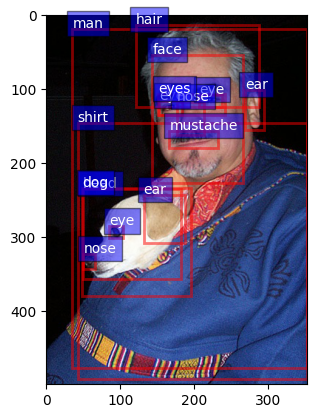

boxes=15


In [ ]:
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)

boxes = pred_boxes[keep_boxes]
objects = torch.argmax(scores[keep_boxes][:,1:], dim=1)

for i in range(len(keep_boxes)):
      kind = objects[i]+1
      bbox = boxes[i, kind * 4: (kind + 1) * 4]
      # bbox = boxes[i]
      if bbox[0] == 0:
          bbox[0] = 1
      if bbox[1] == 0:
          bbox[1] = 1
      cls = classes[objects[i]+1]
      plt.gca().add_patch(
          plt.Rectangle((bbox[0], bbox[1]),
                        bbox[2] - bbox[0],
                        bbox[3] - bbox[1], fill=False,
                        edgecolor='red', linewidth=2, alpha=0.5)
              )
      plt.gca().text(bbox[0], bbox[1] - 2,
                  '%s' % (cls),
                  bbox=dict(facecolor='blue', alpha=0.5),
                  fontsize=10, color='white')
plt.show()
print ('boxes=%d' % (len(keep_boxes)))